<a href="https://colab.research.google.com/github/asgaspar/OpenMOLLI/blob/main/pyOpenMOLLI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **pyOpen-MOLLI**
### Open-source Prototyping myocardial T1 mapping
---
Open-source Prototype of Myocardial T1 mapping (**Open-MOLLI**) using pyPulseq [1] which includes an inversion recovery T1 mapping sequence with a triggering scheme.



The sequence built with this notebook was presented at:

> Andreia S Gaspar, Nuno A da Silva, Rita G Nunes. "ProMyoT1: Open-source Inversion recovery myocardial T1 mapping sequence for fast prototyping". *Proc ISMRM & SMRT Annual Meeting & Exhibition, An online experience*, 2021.

---

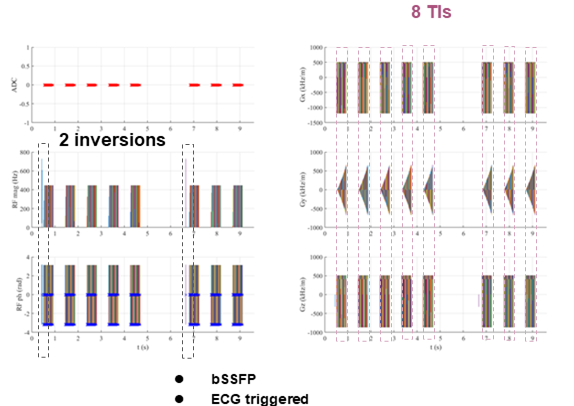






**Contents**
0. Installation and import packages
1. Balanced steady-state free precession (bSSFP) readout
2. Adiabatic Inversion Pulse
3. Build pyOpen-MOLLI

  3.1. Sequence Paramaters
  
  3.2. Inversion RF Pulse
  
  3.3. ECG Triggers
  
  3.4. Acquisition Scheme

  3.5. Add blocks to sequence
  

## Installation and import packages

In order to create a OpenMOLLI.seq file you will need:

pyPulseq package available at: https://github.com/imr-framework/pypulseq.git.

Make sure you restart the runtime in order to use newly installed versions.



In [1]:
# Run dev version for trig
!pip install git+https://github.com/imr-framework/pypulseq.git@dev

  Cloning https://github.com/imr-framework/pypulseq.git (to revision dev) to /tmp/pip-req-build-h4_xkopm
  Running command git clone --filter=blob:none --quiet https://github.com/imr-framework/pypulseq.git /tmp/pip-req-build-h4_xkopm
  Resolved https://github.com/imr-framework/pypulseq.git to commit 1275ea67992dde938a254d9ce3669dcdba638cd5
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/mikgroup/sigpy to /tmp/pip-install-15s82_rr/sigpy_b569cf11a7f1454cb992b4a2c7d5689a
  Running command git clone --filter=blob:none --quiet https://github.com/mikgroup/sigpy /tmp/pip-install-15s82_rr/sigpy_b569cf11a7f1454cb992b4a2c7d5689a
  Resolved https://github.com/mikgroup/sigpy to commit bfd564bc9942f06dab6288923a2f9e7516237bdd
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.5/227.5 kB 2.7 MB/s eta 0:0

Import functions for calculations and to create the sequence blocks. Make sure you run this section twice for correct import.

In [4]:
# Import functions
import copy
from math import pi, sqrt, ceil, floor
from types import SimpleNamespace
import types
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

from pypulseq.Sequence.sequence import Sequence
from pypulseq.calc_duration import calc_duration
from pypulseq.make_adc import make_adc
from pypulseq.make_delay import make_delay
from pypulseq.make_sinc_pulse import make_sinc_pulse
from pypulseq.make_trapezoid import make_trapezoid
from pypulseq.opts import Opts
from pypulseq.make_extended_trapezoid import make_extended_trapezoid
from pypulseq.make_trigger import make_trigger # For trigger



---


# 1. Balanced steady-state free precession (bSSFP) readout

In this section a function to create a balanced Steady-State Free Precession (bSSFP) readout (`bssfp_readout`) is defined to be used in Section 3 to build the pyOpen-MOLLI sequence.

The bSSFP readout is used due to its high signal-to-noise ratio, and short acquisition window (repetition times of the order of 3-6 ms), although it is sensitive to $B_0$ field inhomogeneities (for more information on bSSFP check [Bieri O, Scheffler K. Fundamentals of balanced steady state free precession MRI. J Magn Reson Imaging. 2013;38(1):2–11.](https://onlinelibrary.wiley.com/doi/pdf/10.1002/jmri.24163)).

This readout will have a linear k-space filling trajectory starting from $-k_{max}$, with input parameters:

1.   Sequence object (`seq`): the readout will be appended to this object.
2.   System limits (`system`): used to optimize the gradients and RF pulses for the specific MR system to be used.

Optional:

3. Field-of-view (`fov`) with default `200e-3` m
4. Number of start-up RF pulses (`Nstartup`) with default `11`
5. Number of phase-encoding lines (`Ny`) with default `128`





In [36]:
def bssfp_readout(seq, system, fov=200e-3, Nstartup=11, Ny=128):
    """
    Creates a Balanced steady-state free precession (bSSFP) sequence and adds it
    to the seq object

    Parameters
    ----------
    seq: object
        Sequence object
    system : Opts
        System limits.
    fov : float, optional
        Field-of-view [m]. Default is 0.2 m.
    Nstartup : float, optional
        Number of start-up RF pulses. Default is 11
    Ny : float, optional
        Number of phase encoding lines. Default is 128.
   Returns
    -------
    seq : SimpleNamespace
        Seq object with bSSFP readout
    TR : float
        Repetition time
    Ny : float
        Final number of phase encoding lines.
    """
    # Sequence Parameters
    enc = 'xyz'
    Nx = 128
    thk = 6e-3
    fa = 35  # [deg]

    Nramp =  Nstartup

    # ADC duration (controls TR/TE)
    adc_dur = 2560/2  # [us]

    # RF excitation parameters
    rf_dur = 490  # [us]
    rf_apo = 0.5
    rf_bwt = 1.5  # time_bw_product

    #############################################################################
    #                 Create slice selection pulse and gradient
    rf, g_ss, __ = make_sinc_pulse(flip_angle=fa * pi / 180, system=system, duration=rf_dur * 1e-6, slice_thickness=thk,
                                   apodization=rf_apo, time_bw_product=rf_bwt,return_gz=True)
    g_ss.channel = enc[2]  #z direction

    # Slice refocusing
    g_ss_reph = make_trapezoid(channel=enc[2], system=system, area=-g_ss.area / 2, duration=0.00017 * 2)
    #############################################################################

    # Update RF delay within block
    rf.delay = calc_duration(g_ss) - calc_duration(rf) + rf.delay


    #############################################################################
    #                        Readout gradient and ADC
    delta_k = 1 / fov
    kWidth = Nx * delta_k

    # Readout and ADC
    g_ro = make_trapezoid(channel=enc[0], system=system, flat_area=kWidth, flat_time=(adc_dur)* 1e-6)
    adc = make_adc(num_samples=Nx, duration=g_ro.flat_time, delay=g_ro.rise_time)

    # Readout rewinder
    g_ro_pre = make_trapezoid(channel=enc[0], system=system, area=-g_ro.area/2)

    # Areas for phase-encoding steps
    phaseAreas_tmp = np.arange(0, Ny, 1).tolist()
    phaseAreas = np.dot(np.subtract(phaseAreas_tmp, Ny / 2), delta_k)



    gs8_times = [0, g_ro.fall_time,
                 g_ro.fall_time + g_ro_pre.rise_time,
                 g_ro.fall_time + g_ro_pre.rise_time + g_ro_pre.flat_time,
                 g_ro.fall_time + g_ro_pre.rise_time + g_ro_pre.flat_time + g_ro_pre.fall_time]
    gs8_amp = [g_ro.amplitude, 0, g_ro_pre.amplitude, g_ro_pre.amplitude, 0]
    gx_2 = make_extended_trapezoid(channel=enc[0], times=gs8_times, amplitudes=gs8_amp)

    # Calculate phase encoding gradient duration
    pe_dur = calc_duration(gx_2)


    gx_allExt_times = [0, g_ro_pre.rise_time, g_ro_pre.rise_time + g_ro_pre.flat_time,
                    g_ro_pre.rise_time + g_ro_pre.flat_time + g_ro_pre.fall_time,
                    g_ro_pre.rise_time + g_ro_pre.flat_time + g_ro_pre.fall_time + g_ro.rise_time,
                    g_ro_pre.rise_time + g_ro_pre.flat_time + g_ro_pre.fall_time + g_ro.rise_time + g_ro.flat_time+1e-5,
                    g_ro_pre.rise_time + g_ro_pre.flat_time + g_ro_pre.fall_time + g_ro.rise_time + g_ro.flat_time+1e-5
                    + g_ro.fall_time,
                    g_ro_pre.rise_time + g_ro_pre.flat_time + g_ro_pre.fall_time + g_ro.rise_time + g_ro.flat_time + 1e-5
                    + g_ro.fall_time + g_ro_pre.rise_time,
                    g_ro_pre.rise_time + g_ro_pre.flat_time + g_ro_pre.fall_time + g_ro.rise_time + g_ro.flat_time + 1e-5
                    + g_ro.fall_time + g_ro_pre.rise_time + g_ro_pre.flat_time,
                    g_ro_pre.rise_time + g_ro_pre.flat_time + g_ro_pre.fall_time + g_ro.rise_time + g_ro.flat_time + 1e-5
                    + g_ro.fall_time + g_ro_pre.rise_time + g_ro_pre.flat_time + g_ro_pre.fall_time]
    gx_allExt_amp = [0, g_ro_pre.amplitude, g_ro_pre.amplitude, 0, g_ro.amplitude,  g_ro.amplitude, 0, g_ro_pre.amplitude,  g_ro_pre.amplitude, 0]
    gx_all = make_extended_trapezoid(channel=enc[0], times=gx_allExt_times, amplitudes=gx_allExt_amp)
    #############################################################################



    gzrep_times = [0, g_ss_reph.rise_time,
                   g_ss_reph.rise_time + g_ss_reph.flat_time,
                   g_ss_reph.rise_time + g_ss_reph.flat_time + g_ss_reph.fall_time,
                   g_ss_reph.rise_time + g_ss_reph.flat_time + g_ss_reph.fall_time + calc_duration(g_ro)
                   + 2*calc_duration(g_ro_pre) - 2*calc_duration(g_ss_reph) + 1e-5,
                   g_ss_reph.rise_time + g_ss_reph.flat_time + g_ss_reph.fall_time + calc_duration(g_ro)
                   + 2*calc_duration(g_ro_pre) - 2*calc_duration(g_ss_reph)  + 1e-5 + g_ss_reph.rise_time,
                   g_ss_reph.rise_time + g_ss_reph.flat_time + g_ss_reph.fall_time + calc_duration(g_ro)
                   + 2*calc_duration(g_ro_pre) - 2*calc_duration(g_ss_reph)  + 1e-5 + g_ss_reph.rise_time + g_ss_reph.flat_time,
                   g_ss_reph.rise_time + g_ss_reph.flat_time + g_ss_reph.fall_time + calc_duration(g_ro)
                   + 2*calc_duration(g_ro_pre) - 2*calc_duration(g_ss_reph) + 1e-5 + g_ss_reph.rise_time + g_ss_reph.flat_time + g_ss_reph.fall_time]
    #gzrep_amp = [0, g_ss_reph.amplitude, g_ss_reph.amplitude, 0, 0, g_ss_reph.amplitude, g_ss_reph.amplitude, 0]
    if g_ss_reph.flat_time==0:
      gzrep_times = [0, g_ss_reph.rise_time,
                   g_ss_reph.rise_time + g_ss_reph.fall_time,
                   g_ss_reph.rise_time + g_ss_reph.fall_time + calc_duration(g_ro)
                   + 2*calc_duration(g_ro_pre) - 2*calc_duration(g_ss_reph) + 1e-5,
                   g_ss_reph.rise_time + g_ss_reph.fall_time + calc_duration(g_ro)
                   + 2*calc_duration(g_ro_pre) - 2*calc_duration(g_ss_reph)  + 1e-5 + g_ss_reph.rise_time,
                   g_ss_reph.rise_time + g_ss_reph.fall_time + calc_duration(g_ro)
                   + 2*calc_duration(g_ro_pre) - 2*calc_duration(g_ss_reph) + 1e-5 + g_ss_reph.rise_time+ g_ss_reph.fall_time]
      gzrep_amp = [0, g_ss_reph.amplitude, 0, 0, g_ss_reph.amplitude, 0]
    else:
      gzrep_amp = [0, g_ss_reph.amplitude, g_ss_reph.amplitude, 0, 0, g_ss_reph.amplitude, g_ss_reph.amplitude, 0]

    gzrep_all = make_extended_trapezoid(channel=enc[2], times=gzrep_times, amplitudes=gzrep_amp)


    # Update ADC delay within block
    adc.delay = g_ro_pre.rise_time + g_ro_pre.flat_time + g_ro_pre.fall_time + g_ro.rise_time + 0.5e-5


    # finish timing calculation
    TR =  calc_duration(g_ss) + calc_duration(gx_all)
    TE = TR / 2

    ni_acqu_pattern = np.arange(1, Ny + 1, 1)
    Ny_aq = len(ni_acqu_pattern)
    print('Acquisition window is: %3.2f ms' %(TR * Ny_aq * 1e3))


    rf05 = rf
    rf_waveform = rf.signal
    ############################################################################
    #                          Start-up RF pulses
    #                          (ramp-up of Nramp)
    for nRamp in np.arange(1, Nramp + 1, 1):
        if np.mod(nRamp, 2):
            rf.phase_offset = 0
            adc.phase_offset = 0
        else:
            rf.phase_offset = -pi
            adc.phase_offset = -pi

        rf05.signal = np.divide(nRamp, Nramp) * rf_waveform

        gyPre_2 = make_trapezoid('y', area=phaseAreas[0], duration=pe_dur, system=system)
        gyPre_1 = make_trapezoid('y', area=-phaseAreas[0], duration=pe_dur, system=system)

        gyPre_times = [0, gyPre_2.rise_time,
                       gyPre_2.rise_time + gyPre_2.flat_time,
                       gyPre_2.rise_time + gyPre_2.flat_time + gyPre_2.fall_time,
                       gyPre_2.rise_time + gyPre_2.flat_time + gyPre_2.fall_time + g_ro.flat_time+1e-5,
                       gyPre_2.rise_time + gyPre_2.flat_time + gyPre_2.fall_time + g_ro.flat_time+1e-5
                       + gyPre_1.rise_time,
                       gyPre_2.rise_time + gyPre_2.flat_time + gyPre_2.fall_time + g_ro.flat_time+1e-5
                       + gyPre_1.rise_time + gyPre_1.flat_time,
                       gyPre_2.rise_time + gyPre_2.flat_time + gyPre_2.fall_time + g_ro.flat_time+1e-5
                       + gyPre_1.rise_time + gyPre_1.flat_time + gyPre_1.fall_time]
        gyPre_amp = [0, gyPre_2.amplitude, gyPre_2.amplitude, 0, 0, gyPre_1.amplitude, gyPre_1.amplitude, 0]
        gyPre_all = make_extended_trapezoid(channel=enc[1], times=gyPre_times, amplitudes=gyPre_amp)

        if nRamp == 1:
            seq.add_block(rf05, g_ss)
            seq.add_block(gx_all,  gyPre_all, gzrep_all)
        else:
            seq.add_block(rf05, g_ss)
            seq.add_block(gx_all, gyPre_all, gzrep_all)
    ############################################################################

    ############################################################################
    #           Actual Readout iterate number of phase encoding steps Ny
    for i in np.arange(1, Ny + 1, 1):
        #*******************************
        # Phase cycling
        if np.mod(i + Nramp, 2):
            rf.phase_offset = 0
            adc.phase_offset = 0
        else:
            rf.phase_offset = -pi
            adc.phase_offset = -pi
        #*******************************


        #***************************************************************************************
        #                     Create phase encoding gradients
        if np.mod(Nramp, 2):
            gyPre_2 = make_trapezoid('y', area=phaseAreas[i - 1], duration=pe_dur, system=system)
            if i > 1:
                gyPre_1 = make_trapezoid('y', area=-phaseAreas[np.mod(i + Ny - 2, Ny)],
                                         duration=pe_dur, system=system)
            else:
                gyPre_1 = make_trapezoid('y', area=-phaseAreas[np.mod(i + Ny - 1, Ny)],
                                         duration=pe_dur, system=system)
        else:
            gyPre_2 = make_trapezoid('y', area=phaseAreas[i], duration=pe_dur, system=system)
            if i > 1:
                gyPre_1 = make_trapezoid('y', area=-phaseAreas[np.mod(i + Ny - 2, Ny)],
                                         duration=pe_dur, system=system)
            else:
                gyPre_1 = make_trapezoid('y', area=phaseAreas[np.mod(i + Ny - 2, Ny)],
                                         duration=pe_dur, system=system)

        gyPre_times = [0, gyPre_2.rise_time,
                       gyPre_2.rise_time + gyPre_2.flat_time,
                       gyPre_2.rise_time + gyPre_2.flat_time + gyPre_2.fall_time,
                       gyPre_2.rise_time + gyPre_2.flat_time + gyPre_2.fall_time + g_ro.flat_time + 1e-5,
                       gyPre_2.rise_time + gyPre_2.flat_time + gyPre_2.fall_time + g_ro.flat_time + 1e-5
                       + gyPre_2.rise_time,
                       gyPre_2.rise_time + gyPre_2.flat_time + gyPre_2.fall_time + g_ro.flat_time + 1e-5
                       + gyPre_2.rise_time + gyPre_2.flat_time,
                       gyPre_2.rise_time + gyPre_2.flat_time + gyPre_2.fall_time + g_ro.flat_time + 1e-5
                       + gyPre_2.rise_time + gyPre_2.flat_time + gyPre_2.fall_time]
        gyPre_amp = [0, gyPre_2.amplitude, gyPre_2.amplitude, 0, 0, -gyPre_2.amplitude, -gyPre_2.amplitude, 0]

        # Verify if phase encoding gradient amplitude is not zero
        try:
            gyPre_all = make_extended_trapezoid(channel=enc[1], times=gyPre_times, amplitudes=gyPre_amp)
            flag_zerogy = 0
        except:
            gyPre_times = [0, pe_dur,
                           pe_dur + g_ro.flat_time + 1e-5,
                           pe_dur + g_ro.flat_time + 1e-5 + pe_dur]
            gyPre_amp = [0, gyPre_2.amplitude, 0, 0]
            flag_zerogy=1
        #***************************************************************************************


        # add RF and Slice selecitve gradient
        seq.add_block(rf, g_ss)

        # add Phase and frequency encoding gradients and ADC
        if flag_zerogy == 1:
            seq.add_block(gx_all, gzrep_all,  adc)
        else:
            seq.add_block(gx_all, gyPre_all, gzrep_all, adc)

    return seq, TR, Ny

## 1.1. Creating a bSSFP readout sequence
In this section we show how to generate a bSSFP readout using the defined function `bSSFP_readout` with default parameters.

Acquisition window is: 412.16 ms


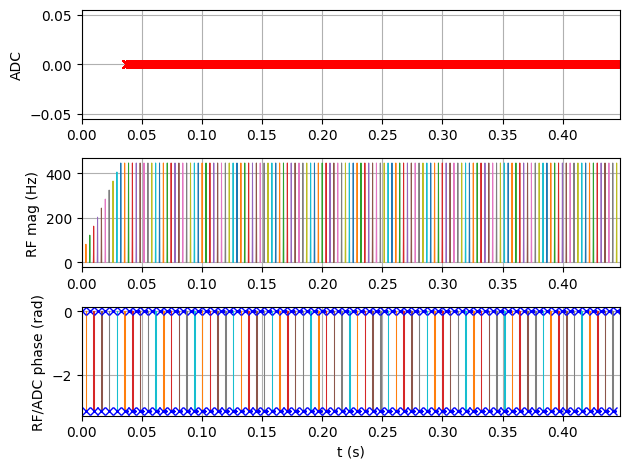

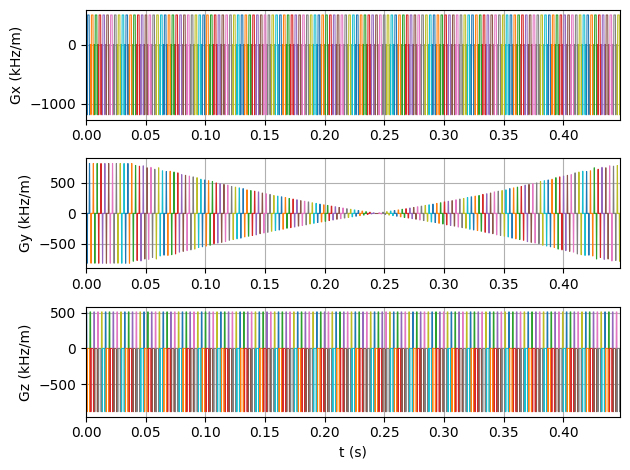

In [37]:
#System limits
system = Opts(max_grad=28, grad_unit='mT/m', max_slew=125,
              slew_unit='T/m/s', rf_ringdown_time=20e-6,
              rf_dead_time=100e-6, adc_dead_time=10e-6)

# Sequence parameters
FOV = 200e-3  # [m]
Ny = 128
Nstartup = 11

# Calculate bSSFP (TR used for trigger delay calculation)
seq_bSSFP, TR, Ny_aq = bssfp_readout(Sequence(system), system, fov=FOV, Nstartup=Nstartup, Ny=Ny)
seq_bSSFP.plot()

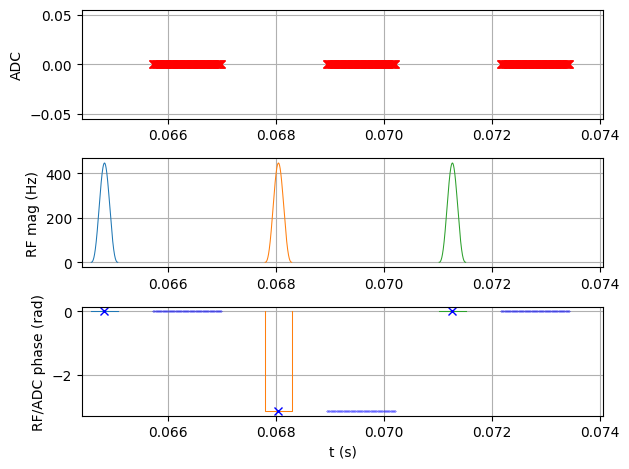

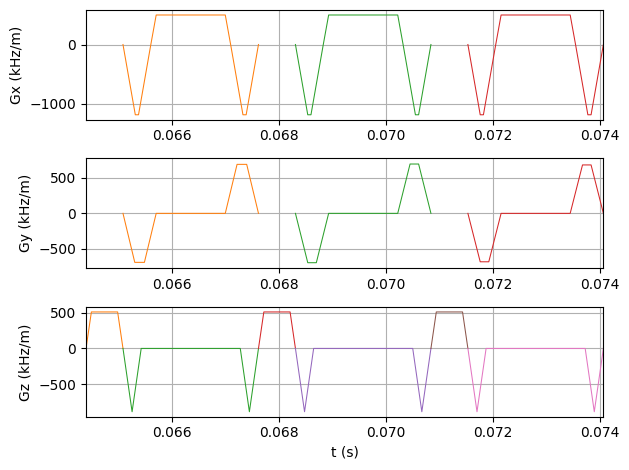

In [39]:
# Plot three TRs
seq_bSSFP.plot(time_range=[TR*20, TR*23])



---

# 2. Adiabatic Inversion Pulse
 Adiabatic RF pulses are robust to $B_1$ nad $B_0$ field inhomogeneities allowing a more robust inversion in the context of cardiac imaging. In this section an adiabatic inversion RF pulse is defined (function `make_hyperSec_pulse`).

The pulse is an hyperbolic secant (HS1) RF pulse with HS1 parameters $\beta$ and $\mu$ according with reference:

> [Kellman P, Herzka DA, Hansen MS. Adiabatic inversion pulses for myocardial T1 mapping. Magn Reson Med. 2014;71(4):1428-1434. doi:10.1002/mrm.24793](https://doi.org/10.1002/mrm.24793)

The hyperbolic secant RF pulse is given by:

$\omega_1 (t) = \omega_0 sech(\beta t)^{1+\mu i} \tag{1}$

where:

*   $\omega_0$ is the peak amplitude [$Hz$];
*   $\beta$ is the frequency modulation parameter [$rad/s$];
*   $\mu$ is phase modulation parameter (dimensionless).

In order to fulfill the adiabatic condition, we should have:

$\omega_0 >> \frac{\sqrt{\mu}\beta}{\pi} $  in [$Hz$].

Therefore we chose $\omega_0 = 1.5 \frac{\sqrt{\mu}\beta}{\pi}$.


In [48]:
def make_hyperSec_pulse(system: Opts = Opts(), duration: float = 0, freq_offset: float = 0,
                        phase_offset: float = 0, center_pos: float = 0.5,
                        delay: float = 0):
    """
    Creates a radio-frequency hyperSec pulse event

    Parameters
    ----------
    system : Opts, optional
        System limits. Default is a system limits object initialised to default values.
    duration : float, optional
        Duration in milliseconds (ms). Default is 0.
    phase_offset : float, optional
        Phase offset in Hertz (Hz). Default is 0.
    center_pos : float, optional
        Position of peak. Default is 0.5
    delay : float, optional
        Delay in milliseconds (ms). Default is 0.
   Returns
    -------
    rf_inv : SimpleNamespace
        Radio-frequency inversion pulse event.
    """
    # HS1 parameters
    Beta = 674.1917339  # rad / s
    mu = 5.01

    # Adiabatic condition
    A0_adiab = sqrt(mu) * Beta / pi  # [Hz]
    A0 = 1.5 * A0_adiab

    # Bandwidth
    BW = Beta*mu
    N = int(round(duration / 1e-6))

    # time
    t = np.arange(1, N + 1) * system.rf_raster_time
    tt = t - (duration * center_pos)

    # Calculations for Eq. (1)
    signal_tmp = complex(1, 1 * mu)
    signal_tmp2 = 1 / np.cosh(np.dot(Beta, tt))

    # Eq. (1)
    signal0 = np.power(signal_tmp2, signal_tmp)  # HyperSec function
    signal_normal = signal0
    signal = A0 * signal_normal  # B1(t)

    # Creat rf_inv object
    rf_inv = SimpleNamespace()
    rf_inv.type = 'rf'
    rf_inv.signal = signal
    rf_inv.t = t
    rf_inv.freq_offset = freq_offset
    rf_inv.phase_offset = phase_offset
    rf_inv.dead_time = system.rf_dead_time
    rf_inv.ringdown_time = system.rf_ringdown_time
    rf_inv.delay = delay
    rf_inv.shape_dur = duration


    if rf_inv.dead_time > rf_inv.delay:
        rf_inv.delay = rf_inv.dead_time

    if rf_inv.ringdown_time > 0:
        t_fill = np.arange(1, round(rf_inv.ringdown_time / 1e-6) + 1) * 1e-6
        rf_inv.t = np.concatenate((rf_inv.t, rf_inv.t[-1] + t_fill))
        rf_inv.signal = np.concatenate((rf_inv.signal, np.zeros(len(t_fill))))

    negative_zero_indices = np.where(rf_inv.signal == -0.0)
    rf_inv.signal[negative_zero_indices] = 0

    return rf_inv

## 2.1. Creating an adiabatic inversion RF pulse

After the definition of the function  `make_hyperSec_pulse`, it is possible to create the object `rf_inv` which incudes the `signal` (complex) and the RF pulse time `t`.

The next section includes the plot of the magnitude and phase of the RF inversion pulse.

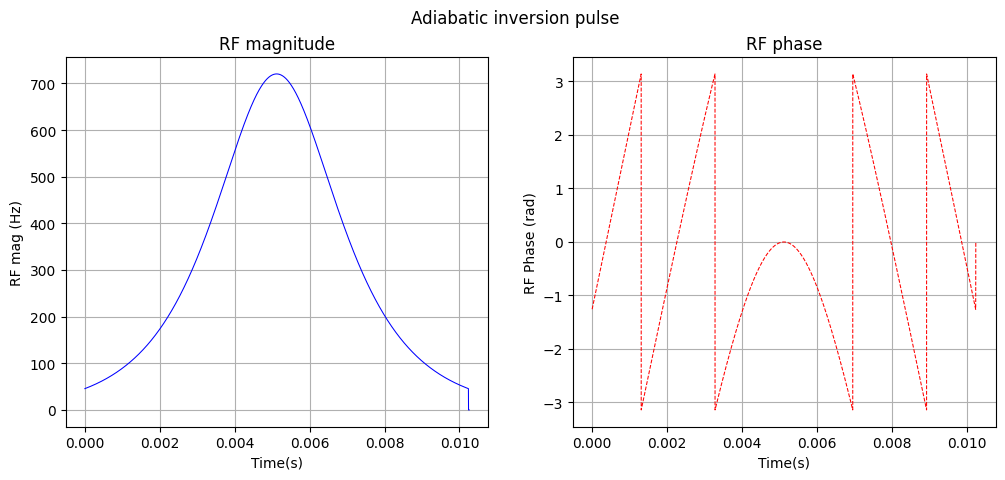

In [49]:
#System limits
system = Opts(max_grad=28, grad_unit='mT/m', max_slew=125,
              slew_unit='T/m/s', rf_ringdown_time=20e-6,
              rf_dead_time=100e-6, adc_dead_time=10e-6)

rf_inv = make_hyperSec_pulse(system=system, duration=10.24 * 1e-3)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(12)
fig.suptitle('Adiabatic inversion pulse')

# plot magnitude of inversion RF pulse
ax1.plot(rf_inv.t,np.absolute(rf_inv.signal),'b')
ax1.set_xlabel('Time(s)')
ax1.set_ylabel('RF mag (Hz)')
ax1.set_title('RF magnitude')
ax1.grid(1)

# plot phase of inversion RF pulse
ax2.plot(rf_inv.t,np.angle(rf_inv.signal),'r--')
ax2.set_xlabel('Time(s)')
ax2.set_ylabel('RF Phase (rad)')
ax2.set_title('RF phase')
ax2.grid(1)

---


# 3. Build pyOpenMOLLI


pyOpenMOLLI is a sequence for myocardial T1 mapping which includes an inversion recovery with a triggering scheme. The building blocks of the scheme as well as their interaction is presented in this section.

Before running this section, both functions `bssfp_readout` and `make_hyperSec_pulse` should be defined.

## 3.1. Sequence parameters

First, the **system hardware limits** need to be defined. These are used to optimize the gradients, RF pulses, etc.. for the specific MR system to be used.

Then you can define **sequence parameters** such as field-of-view (`FOV`), number of phase encoding lines (`Ny`), and the number of start-up RF pulses (`Nstartup`).


In [50]:
# System limits
system = Opts(max_grad=28, grad_unit='mT/m', max_slew=125,
              slew_unit='T/m/s', rf_ringdown_time=20e-6,
              rf_dead_time=100e-6, adc_dead_time=10e-6)

seq = Sequence(system)

# Sequence Parameters
FOV = 200e-3  #[m]
Ny = 128
Nstartup = 11

To correctly calculate the trigger delay time for ECG trigger, we need to **pre-calculate the repetition time** (`TR`) for the bSFFP readout with the chosen sequence parameters. For that, we use the function `bssfp_readout` (defined in Section 1).

This function will also print the acquisition window of the readout.


In [51]:
# Calculate TR
_, TR, Ny_aq = bssfp_readout(Sequence(system), system, fov=FOV, Nstartup=Nstartup, Ny=Ny)

Acquisition window is: 412.16 ms


Finally, the set of crushers to be applied before each readout is defined. The crusher before the first readout of each inversion will be the same (i.e. `gzSpoil_INV`).


In [52]:
# Calculate Crushers
gzSpoil_INV = make_trapezoid('z', area=-3e3, duration=9.5e-3, system=system)
FlatArea_crusher = [0, 0.4e3, 0.32e3, 0.27e3, 0.32e3, 0, 0.53e3, 0.32e3]
FlatTime_crusher = [0, 5e-4, 6.3e-4, 6.3e-4, 6.3e-4, 0, 9.3e-4, 6.3e-4]
crushers_in_between = 1

## 3.2. Inversion RF pulse

Here we use the function `make_hyperSec_pulse` (defined in Section 2) to generate the  adiabatic inversion pulse object `rf_inv` to be use in section of block addition (Section 3.5).

In [53]:
# Create adiabatic inversion pulse
rf_inv = make_hyperSec_pulse(system=system, duration=10.24 * 1e-3)
InvDur = rf_inv.t[-1]  # duration

## 3.3. Triggers

Triggers for prospective ECG gating are essential in this sequence, they allow to do the readout acquisitions in the same cardiac phase (i.e. diastole). With that aim, the trigger delay was chosen as 550 ms.

To get the desired trigger delay at the time of the first signal collection (ADC), we must account for the start-up RF pulses.

In [54]:
Tdelay_trig = 550e-3  # [s]
trig = make_trigger(channel='physio1', delay=100e-6, duration=Tdelay_trig - (Nstartup + 1) * TR, system=system)

For the triggers between inversions (`trig_BetweenInversion`), where no image is acquired, we don't need to account for the ramp-up pulses.

In [55]:
trig_BetweenInversion = make_trigger(channel='physio1', delay=100e-6, duration=Tdelay_trig, system=system)

Finally, a special trigger is built within the `for` loop of block addition (in section 3.5) to account for the intended inversion time, and inversion pulse duration:


```
trig_inv = make_trigger(channel='physio1', delay=100e-6,duration=Tdelay_trig - delayINV - InvDur - calc_duration(gzSpoil_INV) - (Nstartup + 1) * TR,system=system)
```

## 3.4. Acquisition Scheme and Inversion Time

 The acquisition scheme 5(3)3 is applied, defined by the parameters:

`NImage_perInv` - number of images per inversion

`Nrecover_bwtInv` - number of recovery heart beats between inversions

`TI_Vector` - Initial Inversion times in [$s$]

`N_inversion` - Number of inversions


In [56]:
# Scheme 5(3)3
NImage_perInv = [5, 3]
Nrecover_btwInv = [3]
TI_Vector = [0.100, 0.100 + 0.08]  # [s]     TI1 minimum TI of 100 ms, TI increment of 80 sec, Messroghli 2007
TI_Vector_real = np.zeros(np.shape(TI_Vector))  # Initialize vector for final TI
N_inversion = np.shape(NImage_perInv)  # Number of inversions

print('Number of inversion:', N_inversion[0])
print('Number of images per inversion:', NImage_perInv )
print('Number of recovery heart beats between inversion:', Nrecover_btwInv )

Number of inversion: 2
Number of images per inversion: [5, 3]
Number of recovery heart beats between inversion: [3]


**Minimum Inversion Time**

The inversion time (TI) is evaluated during the add block section, to assert the possibility of having a TI of 100 ms acording with the readout time up to the centre of k-space acquisition, where the overall image contrast is defined.

If `TR = 2.6 ms`, the number of start-up pulses `Nstartup=11`, the number of phase encoding lines `Ny = 128` (with linear k-space filling), and also accounting for the crusher duration after the inversion pulse (`gzSpoil_INV`), it is possible to calculate the minimum attainable TI:


In [57]:
TI_min_attainable = (Nstartup + Ny/2) * TR + calc_duration(gzSpoil_INV)
print('Minimum TI: %3.0f'  %(TI_min_attainable*1e3), 'ms')

Minimum TI: 251 ms


## 3.5. Add blocks to sequence

Finally, we can use the created objects (triggers, inversion pulse and crushers), the readout generation function (`bssfp_readout`), and the acquisition scheme parameters to iterate between inversions and add all the sequence blocks.

In [58]:
# Iterate between Inversions
for nInv in np.arange(N_inversion[0]):
    print('----------- Inversion %3.0f -----------' %(nInv+1) )
    if nInv > 0:
      for nRec in np.arange(Nrecover_btwInv[nInv-1]):
        seq.add_block(trig_BetweenInversion)

    #***************************************************************************************************
    #                          Verify minimum possible TI
    #                   (nearest to TI_Vector[0], i.e. 100 ms)
    try:
        assert (all(TI_Vector[nInv] >= TI_min_attainable)) # verify if TI_vector value is possbile
        delayINV = TI_Vector[nInv] - TI_min_attainable # calculate delay for TI
        TI_Vector_real[nInv] = TI_Vector[nInv]
        seq.addBlock(make_delay(delayINV))

    except:
        delayINV = 0
        if nInv == 0:
            TI_Vector_real[nInv] = TI_min_attainable
        else:
            TI_Vector_real[nInv] = TI_min_attainable + np.diff(TI_Vector)  # add increment i.e. 80 ms

        print('TI changed from ', TI_Vector[nInv] * 1e3, ' ms to %3.0f ms' %(TI_Vector_real[nInv] * 1e3))
     #****************************************************************************************************

    trig_inv = make_trigger(channel='physio1', delay=100e-6,
                          duration=Tdelay_trig - delayINV - InvDur - calc_duration(gzSpoil_INV) - (
                                      Nstartup + 1) * TR,
                          system=system)
    seq.add_block(trig_inv)

    ##########################################################################################
    # Inversion pulse
    seq.add_block(rf_inv)
    ##########################################################################################

    seq.add_block(gzSpoil_INV) # crusher

    if delayINV > 0:
        seq.add_block(make_delay(delayINV))  # Delay for min attainable TI

    # Add respective number of readouts after each inverion
    for nACQ in np.arange(NImage_perInv[nInv]):

        # Only after first readout we will calculate gzCrusher_im and trig_crush
        if nACQ > 0:
            #Crusher before image
            gzCrusher_im = make_trapezoid('z', flat_area=FlatArea_crusher[nACQ], flat_time=FlatTime_crusher[nACQ],
                                          system=system)

            ##########################################################################################
            # Add trigger between images of the same inversion
            trig_crush = make_trigger(channel='physio1', delay=100e-6,
                                    duration=Tdelay_trig - (Nstartup + 1) * TR - calc_duration(gzCrusher_im),
                                    system=system)

            seq.add_block(trig_crush)
            ##########################################################################################

            if crushers_in_between:
                seq.add_block(gzCrusher_im)  # crusher before image acquisition
            else:
                seq.add_block(make_delay(calc_duration(gzCrusher_im)))

        ##########################################################################################
        # bSSFP readout
        seq, TR, _ = bssfp_readout(seq, system,fov=FOV, Nstartup=Nstartup, Ny=Ny)
        ##########################################################################################

print('---------------  Done  ---------------')
print('First Inversion Time',  TI_Vector_real, 's')

----------- Inversion   1 -----------
TI changed from  100.0  ms to 251 ms
Acquisition window is: 412.16 ms
Acquisition window is: 412.16 ms
Acquisition window is: 412.16 ms
Acquisition window is: 412.16 ms
Acquisition window is: 412.16 ms
----------- Inversion   2 -----------
TI changed from  180.0  ms to 331 ms
Acquisition window is: 412.16 ms
Acquisition window is: 412.16 ms
Acquisition window is: 412.16 ms
---------------  Done  ---------------
First Inversion Time [0.251 0.331] s


---

After adding the sequence blocks, the sequence `seq` can be displayed.

Here we can see **two parts - one for each inversion**:

*   The first inversion is followed by five readouts.
*   The second inversion is followed by three readouts.

Each of these readouts will produce an T1 weighted image.

The time interval between readouts represents the trigger delay of `550` ms. The time between inversion blocks (`2200` ms) corresponds to 3 recovery triggers plus the trigger for the first image of the second inversion block.

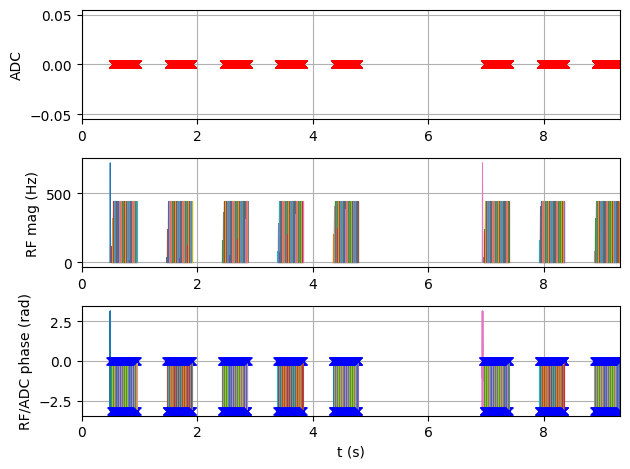

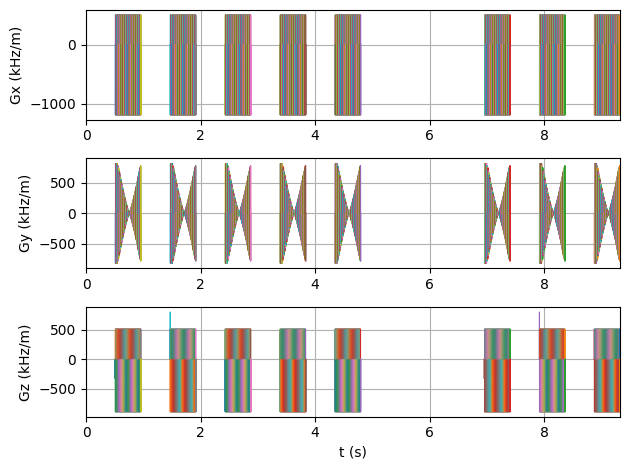

In [59]:
# Plot complete sequence
seq.plot()

We can also show a zoom-in at the begining of the sequence (i.e. from the first inversion RF pulse), where the ramp-up RF pulses of the first readout with respective gradients, and then the first ADC acquisitions can be seen.

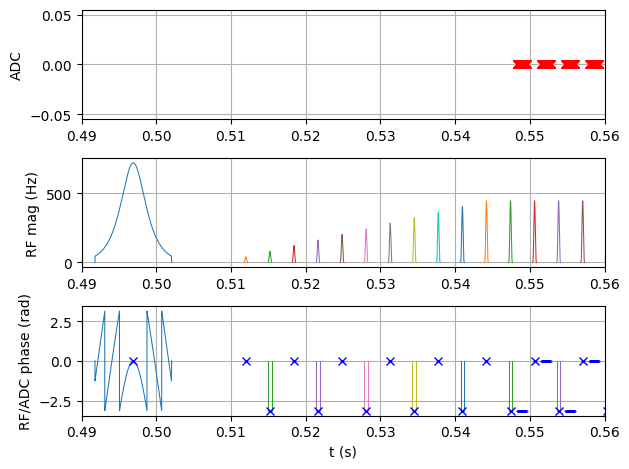

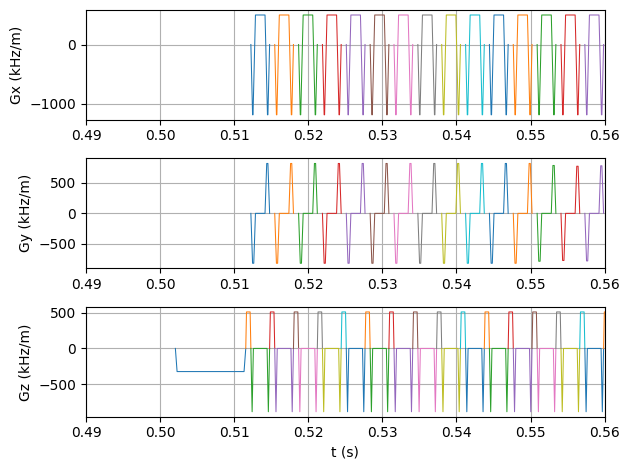

In [60]:
# Plot initial blocks of the sequence
seq.plot(time_range=[0.49, 0.56])

Then we can download the sequenec file `*.seq`, and run in the scanner.

In [61]:
seq_to_write = copy.deepcopy(seq)
seq_to_write.write('pyOpenMOLLI.seq')

from google.colab import files
# Download Colab VM fiels to local
files.download('pyOpenMOLLI.seq')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>